In [1]:
import requests
import numpy as np
import pandas as pd
from openai import OpenAI
import json

In [2]:
DATA_PATH = r"D:\Personal\OneDrive\Gabrilyi\arxiv_project\arxiv_metadata_sample.parquet.gzip"
CATEGORIES_PATH = r"..\data\categories.json"

In [3]:
def load_data(p):
    return pd.read_parquet(p)

def load_categories(p):
    with open(p, "r") as f:
        return json.load(f)

In [5]:
df = load_data(DATA_PATH)
display(df.head())
print(df.shape)

,id,title,abstract,categories,update_date,title_words,abstract_words,mapped_categories,amount_categories,update_year,super_categories,super_category,amount_super_categories
0,2007.13034,Mask2CAD: 3D Shape Prediction by Learning to S...,Object recognition has seen significant prog...,"[cs.CV, cs.LG, eess.IV]",2020-07-28,10,193,"[Computer Vision and Pattern Recognition, Mach...",3,2020,"[Computer Science, Computer Science, Electrica...",Computer Science,2
1,1209.5218,A New Continuous-Time Equality-Constrained Opt...,"In equality-constrained optimization, a stan...",[cs.NE],2020-03-10,9,157,[Neural and Evolutionary Computing],1,2020,[Computer Science],Computer Science,1
2,2306.12063,High Throughput Open-Source Implementation of ...,This paper describes the design and C99 impl...,"[cs.IT, math.IT]",2023-06-22,13,187,"[Information Theory, Information Theory]",2,2023,"[Computer Science, Computer Science]",Computer Science,1
3,2009.02286,Vulnerability of Face Recognition Systems Agai...,Rounding confidence score is considered triv...,"[cs.CV, cs.CR, cs.LG, stat.ML]",2020-09-07,10,219,"[Computer Vision and Pattern Recognition, Cryp...",4,2020,"[Computer Science, Computer Science, Computer ...",Computer Science,2
4,2307.1646,On Krylov subspace methods for skew-symmetric ...,Krylov subspace methods for solving linear s...,"[math.NA, cs.NA]",2023-08-01,11,154,"[Numerical Analysis, Numerical Analysis]",2,2023,"[Computer Science, Computer Science]",Computer Science,1


(70000, 13)


In [ ]:
# df_cs = df[df["categories"].apply(lambda x: x.startswith("cs."))]
# print(df_cs.shape)

# categories_cs = {k: v for k, v in categories.items() if "cs" in k}
# print(len(categories_cs))

In [ ]:
# # Sort categories by number of papers
# top_categories = df_cs["categories"].value_counts().sort_values(ascending=False)
# top_categories = top_categories[top_categories > 1000]

# len(top_categories)

# # Get N papers for each category
# N = 1000

# def get_papers(df, N):
#     return pd.concat([df[df["categories"] == c].sample(N) for c in df["categories"].unique()])

# df_cs_top = df_cs[df_cs["categories"].isin(top_categories.index)]

# df_cs_top_sample = get_papers(df_cs_top, N)

# print(df_cs_top_sample.shape)

In [ ]:
# Make sure to `pip install openai` first

client = OpenAI(base_url="http://localhost:5000/v1", api_key="lm-studio")


def get_embeddings(texts, model="second-state/All-MiniLM-L6-v2-Embedding-GGUF"):
   """
   texts: list of strings
   """

   return client.embeddings.create(input = texts, model=model)

In [6]:
# df_sampled = df.sample(10000)

# texts = df_sampled["abstract"].tolist()
# display(texts[:5])
# embeddings = get_embeddings(texts)
PARQUETPATH= r"D:\Personal\OneDrive\Gabrilyi\arxiv_project\arxiv_metadata.parquet.gzip"
df = pd.read_parquet(PARQUETPATH)
print(df.shape)
df.head()

(2477303, 5)


,id,title,abstract,categories,update_date
0,704.0001,Calculation of prompt diphoton production cros...,A fully differential calculation in perturba...,hep-ph,2008-11-26
1,704.0002,Sparsity-certifying Graph Decompositions,"We describe a new algorithm, the $(k,\ell)$-...",math.CO cs.CG,2008-12-13
2,704.0003,The evolution of the Earth-Moon system based o...,The evolution of Earth-Moon system is descri...,physics.gen-ph,2008-01-13
3,704.0004,A determinant of Stirling cycle numbers counts...,We show that a determinant of Stirling cycle...,math.CO,2007-05-23
4,704.0005,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,In this paper we show how to compute the $\L...,math.CA math.FA,2013-10-15


: 

In [49]:
# Save embeddings
embeddings = np.array([embeddings.data[i].embedding for i in range(len(embeddings.data))])
np.save(r"embeddings_abstracts_clean.npy", embeddings)

# Save texts
with open(r"texts_abstracts_clean.txt", "w") as f:
    f.write("\n".join([t.replace("\n", " ") for t in texts]))

In [55]:
embeddings = np.load(r"embeddings_abstracts_clean.npy")
classes = df_sampled["mapped_categories"].apply(lambda x: x[0]).tolist()


label2id = {label: i for i, label in enumerate(np.unique(classes))}

labels = np.array([label2id[label] for label in classes])


In [56]:
from sklearn.cluster import KMeans

# Number of clusters is set to the number of unique labels
num_clusters = len(np.unique(labels))

# Perform KMeans clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score

# Adjusted Rand Index (ARI)
ari = adjusted_rand_score(labels, cluster_labels)
print(f"Adjusted Rand Index (ARI): {ari:.4f}")

# Normalized Mutual Information (NMI)
nmi = normalized_mutual_info_score(labels, cluster_labels)
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")

# Silhouette Score
silhouette_avg = silhouette_score(embeddings, labels)
print(f"Silhouette Score: {silhouette_avg:.4f}")

o:\Programs\Python\3_11_6\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index (ARI): 0.6957
Normalized Mutual Information (NMI): 0.7464
Silhouette Score: 0.0588


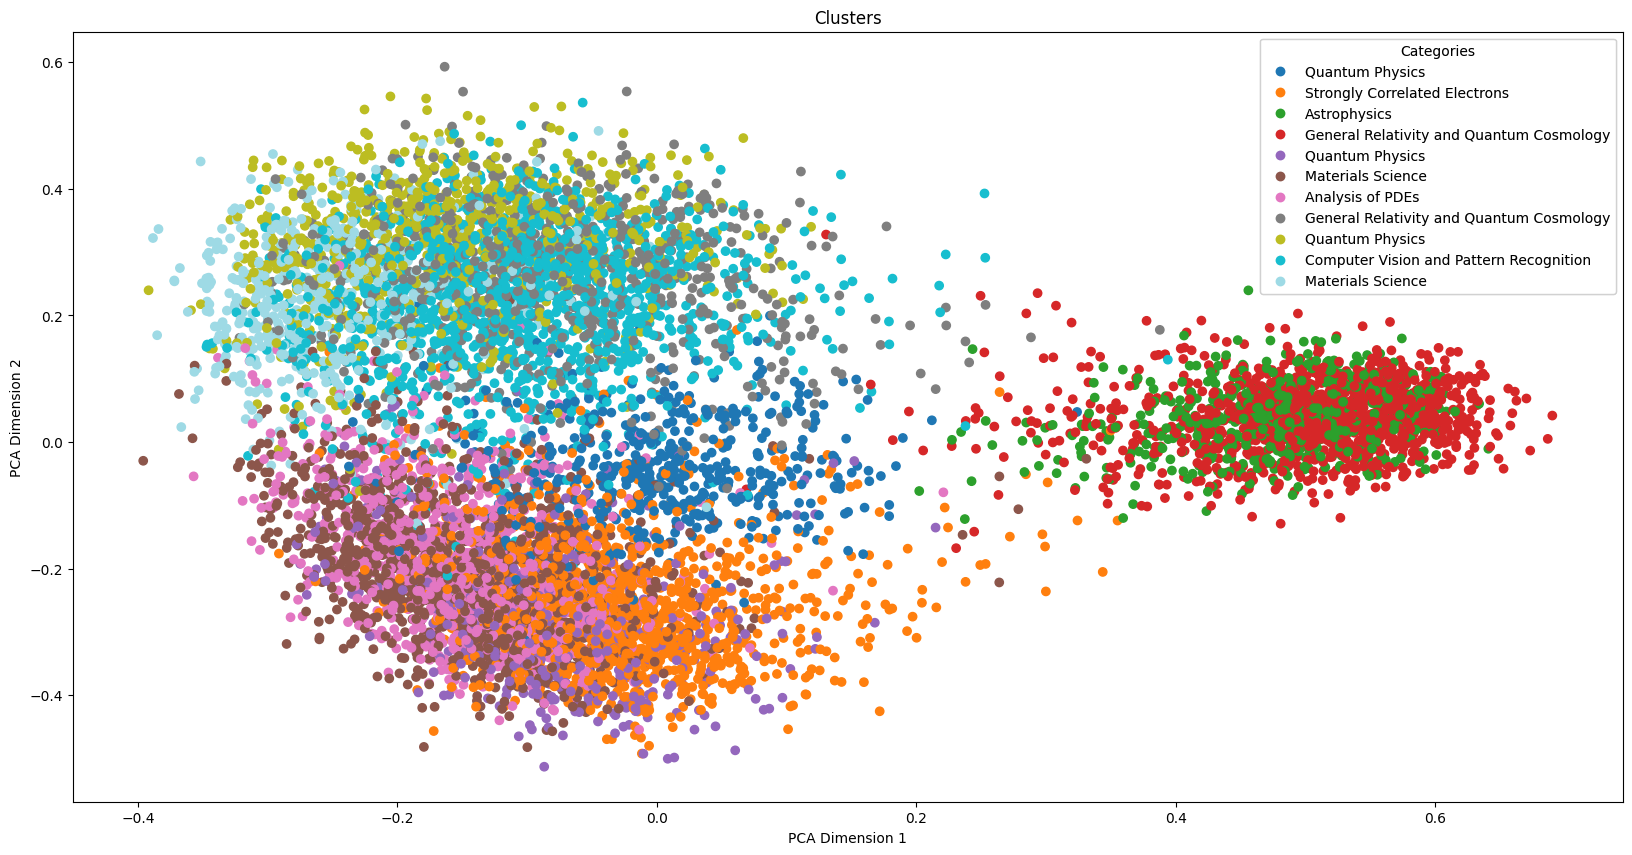

In [57]:
# Visualize the clusters
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Perform PCA to reduce the dimensionality of the embeddings
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Plot the clusters
plt.figure(figsize=(20, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap="tab20")
plt.title("Clusters")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
# plt.colorbar()
legend1 = plt.legend(handles=scatter.legend_elements()[0], labels=classes, title="Categories")
plt.gca().add_artist(legend1)
plt.show()

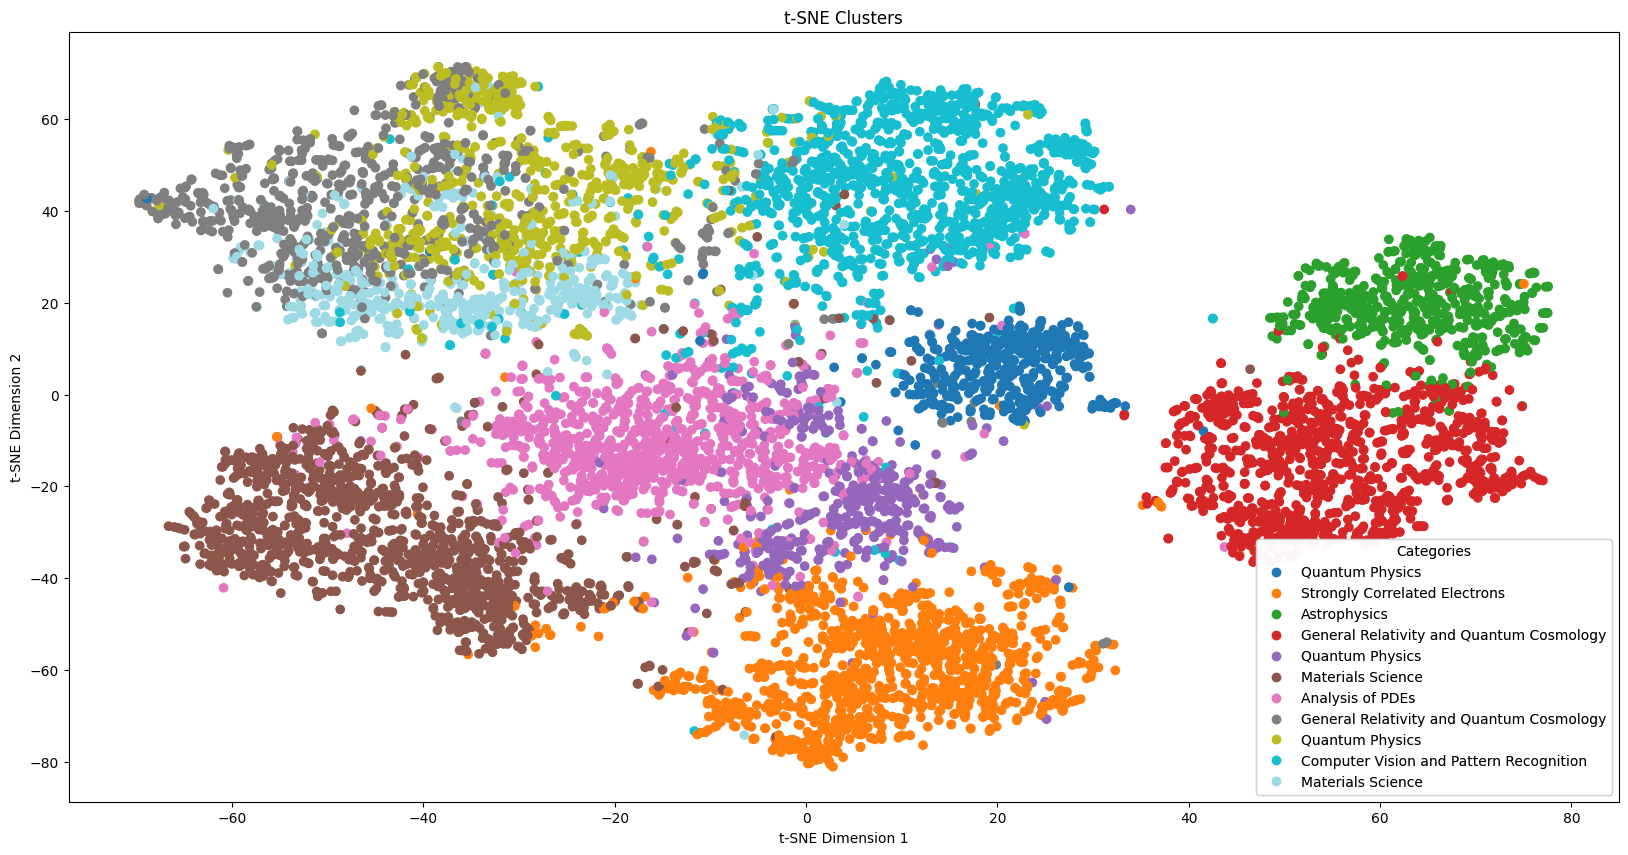

In [58]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Perform t-SNE to reduce the dimensionality of the embeddings
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings)

# Plot the clusters using t-SNE
plt.figure(figsize=(20, 10))
scatter_tsne = plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=labels, cmap="tab20")
plt.title("t-SNE Clusters")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")

# Create a legend with the categories
legend_tsne = plt.legend(handles=scatter_tsne.legend_elements()[0], labels=classes, title="Categories")
plt.gca().add_artist(legend_tsne)

plt.show()


o:\Programs\Python\3_11_6\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


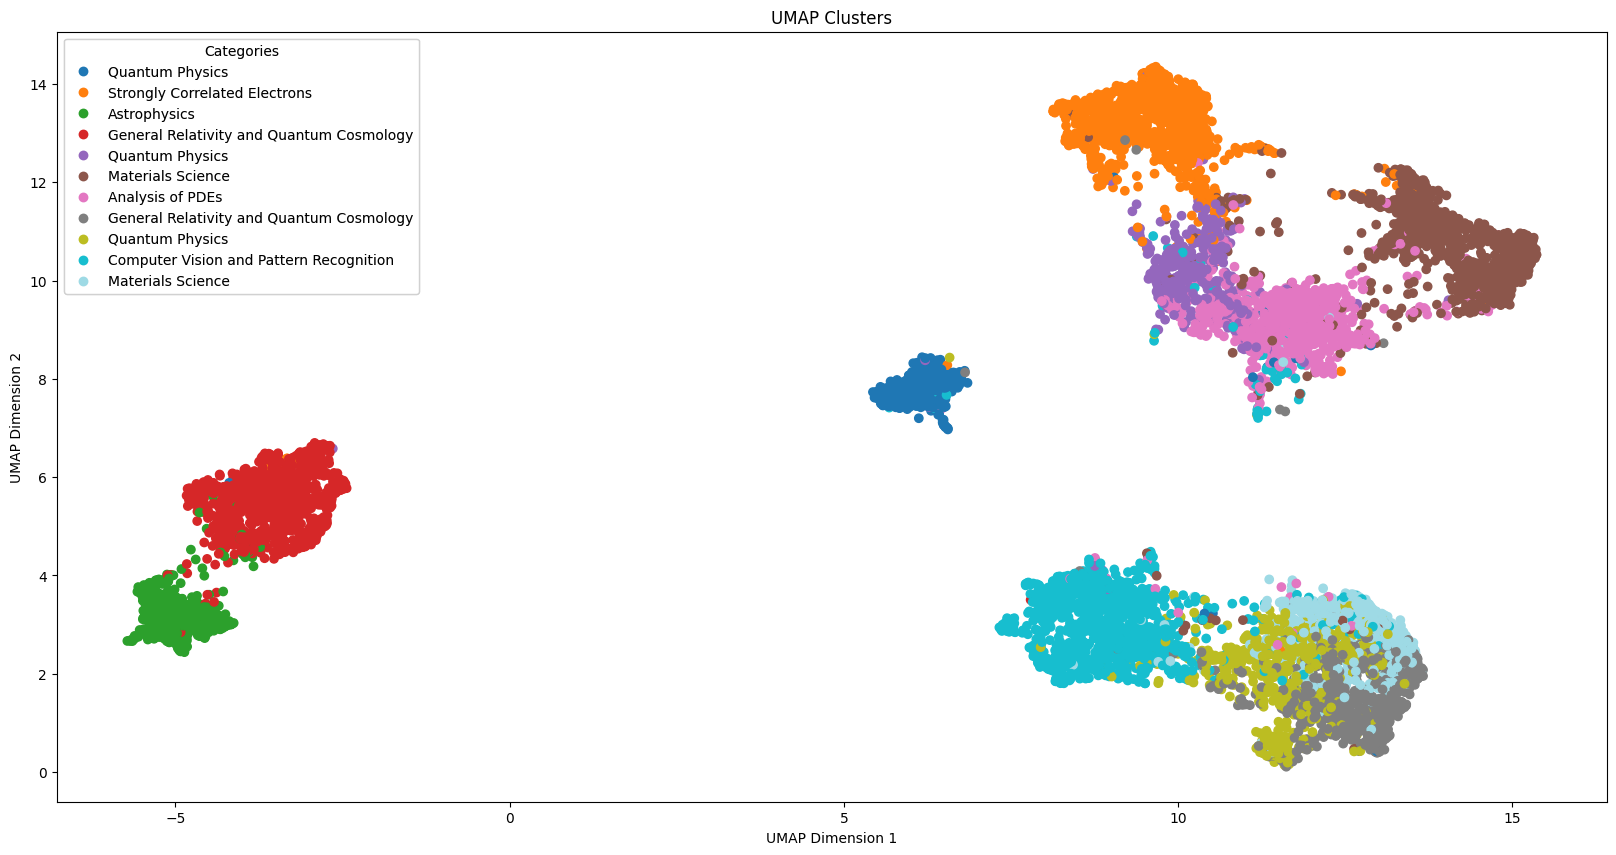

In [59]:
#umap-learn
import matplotlib.pyplot as plt
import umap.umap_ as umap

# Perform UMAP to reduce the dimensionality of the embeddings
umap_reducer = umap.UMAP(n_components=2, random_state=42)
embeddings_umap = umap_reducer.fit_transform(embeddings)

# Plot the clusters using UMAP
plt.figure(figsize=(20, 10))
scatter_umap = plt.scatter(embeddings_umap[:, 0], embeddings_umap[:, 1], c=labels, cmap="tab20")
plt.title("UMAP Clusters")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")

# Create a legend with the categories
legend_umap = plt.legend(handles=scatter_umap.legend_elements()[0], labels=classes, title="Categories")
plt.gca().add_artist(legend_umap)

plt.show()
